In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax


In [2]:
# DataFrame 형태로 데이터를 읽어온다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

# 유저-영화 평점 데이터 "u.data" 로드
ratings = pd.read_csv('./u.data', 
                     names=r_cols,
                      sep='\t',
                      encoding='latin-1'
                     )
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
# 학습, 테스트 구분하기
ratings_train, ratings_test = train_test_split(ratings,
                                              test_size=0.2,
                                              shuffle=True,
                                              random_state=2022)

In [4]:
# 추천 시스템 metric : RMSE (keras에는 RMSE 메소드가 없어서 만들어줘야 함)
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [5]:
# 잠재 요인 수 
K = 200

# 전체 평점 평균
mu = ratings_train.rating.mean()  # b

# 사용자id, 영화id의 최대값을 구한다.(bias term의 크기 1을 고려하여 +1을 해준다)
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

In [6]:
print('사용자 개수 max값:', M)
print('아이템 개수 max값:', N)

사용자 개수 max값: 944
아이템 개수 max값: 1683


# 케라스 모델 생성

In [7]:
user = Input(shape=(1, ))
item = Input(shape=(1, ))

# P,Q 임베딩 
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

# 사용자, 아이템 평가 경향(bias)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [8]:
# 사용자 임베딩과 아이템 임베딩 간 dot product
R = layers.dot([P_embedding, Q_embedding], axes=(2, 2))  # 2번째 축(K)끼리 연산을 하겠다.
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)

model = Model(inputs=[user, item], outputs=R)

# 컴파일(환경구성)
model.compile(
    loss = RMSE, 
    optimizer = SGD(),
    metrics = [RMSE]
)

model.summary()
# 사용자 수가 944, 잠재요인 수가 200 -> 944x200 = 188800

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_2[0][0]']                
                                                                                              

In [9]:
%%time
result = model.fit(
    # x데이터, y데이터 지정
    x = [ratings_train.user_id.values, 
        ratings_train.movie_id.values], 

    y = ratings_train.rating.values - mu,  
    
    epochs = 100,  # 전체 데이터를 학습하는 횟수
    batch_size = 256,  # 한 번에 몇 개씩 데이터를 학습할지
    
    # 검증 데이터 지정
    validation_data = (
        [ratings_test.user_id.values, 
         ratings_test.movie_id.values], 
         ratings_test.rating.values - mu
    )
)


Epoch 1/100


2022-07-20 17:07:22.611577: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 [==============================] - 1s 2ms/step - loss: 5.2644 - RMSE: 1.1252 - val_loss: 5.0054 - val_RMSE: 1.1200
Epoch 2/100
313/313 [==============================] - 1s 2ms/step - loss: 4.7752 - RMSE: 1.1233 - val_loss: 4.5464 - val_RMSE: 1.1180
Epoch 3/100
313/313 [==============================] - 0s 2ms/step - loss: 4.3437 - RMSE: 1.1213 - val_loss: 4.1415 - val_RMSE: 1.1162
Epoch 4/100
313/313 [==============================] - 1s 2ms/step - loss: 3.9628 - RMSE: 1.1195 - val_loss: 3.7842 - val_RMSE: 1.1146
Epoch 5/100
313/313 [==============================] - 1s 2ms/step - loss: 3.6268 - RMSE: 1.1177 - val_loss: 3.4690 - val_RMSE: 1.1130
Epoch 6/100
313/313 [==============================] - 1s 2ms/step - loss: 3.3303 - RMSE: 1.1160 - val_loss: 3.1910 - val_RMSE: 1.1116
Epoch 7/100
313/313 [==============================] - 1s 2ms/step - loss: 3.0689 - RMSE: 1.1148 - val_loss: 2.9457 - val_RMSE: 1.1103
Epoch 8/100
313/313 [==============================] - 1s 2ms/step 

313/313 [==============================] - 1s 3ms/step - loss: 1.1122 - RMSE: 1.0964 - val_loss: 1.1103 - val_RMSE: 1.0937
Epoch 62/100
313/313 [==============================] - 1s 3ms/step - loss: 1.1118 - RMSE: 1.0966 - val_loss: 1.1101 - val_RMSE: 1.0937
Epoch 63/100
313/313 [==============================] - 1s 3ms/step - loss: 1.1117 - RMSE: 1.0964 - val_loss: 1.1099 - val_RMSE: 1.0936
Epoch 64/100
313/313 [==============================] - 1s 3ms/step - loss: 1.1115 - RMSE: 1.0965 - val_loss: 1.1097 - val_RMSE: 1.0936
Epoch 65/100
313/313 [==============================] - 1s 3ms/step - loss: 1.1112 - RMSE: 1.0964 - val_loss: 1.1095 - val_RMSE: 1.0936
Epoch 66/100
313/313 [==============================] - 1s 3ms/step - loss: 1.1112 - RMSE: 1.0964 - val_loss: 1.1094 - val_RMSE: 1.0936
Epoch 67/100
313/313 [==============================] - 1s 3ms/step - loss: 1.1110 - RMSE: 1.0964 - val_loss: 1.1092 - val_RMSE: 1.0936
Epoch 68/100
313/313 [==============================] - 1s 3m

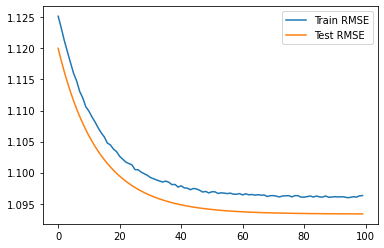

In [10]:
# 학습 과정 시각화
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.legend()
plt.show()

In [11]:
# 모델로 test 데이터 예측
user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

predictions = model.predict([user_ids, movie_ids]) + mu

# 예측값들 확인
print(predictions[:15])

[[3.5680225]
 [3.4998355]
 [3.5278442]
 [3.5737002]
 [3.5789084]
 [3.4878166]
 [3.5298328]
 [3.6062264]
 [3.5720482]
 [3.5581486]
 [3.4897773]
 [3.5288968]
 [3.4921098]
 [3.5116162]
 [3.527199 ]]


In [12]:
# 실제값
print(ratings_test[:15])

       user_id  movie_id  rating  timestamp
59286      643       268       4  891450748
71695      470       319       3  879178216
70788      897       679       5  879991630
48299      545       199       4  880347770
16144      194       127       5  879520813
67827      814       665       4  885411204
59373      870       517       2  875680597
32506      326       181       4  879875592
48843      624       124       4  879792358
3767       106       213       4  881453065
10090      201       527       3  884111360
24858      390       277       2  879694123
43351      463       224       3  877385181
49282      627        76       3  879530173
11074      381       771       2  892696557


In [13]:
import numpy as np

# 넘파이를 활용한 RMSE 함수
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [15]:
# ravel : 1차원으로 변환
y_pred = np.ravel(predictions, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

1.0953973736412905